# 쉬펄10 resnet18 baseline.
- pytorch
- resnet 18
- early stop ( https://github.com/Bjarten/early-stopping-pytorch )


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


# 데이터 확인

In [2]:
print("target 들 ")
glob('./data/train/*')


target 들 


['./data/train\\airplane',
 './data/train\\automobile',
 './data/train\\bird',
 './data/train\\cat',
 './data/train\\deer',
 './data/train\\dog',
 './data/train\\frog',
 './data/train\\horse',
 './data/train\\ship',
 './data/train\\truck']

## train set 확인

In [3]:
print("귀찮네 그냥 파일 다 넣고 액셀로 분류해주지")


## train set

airplane = glob('./data/train/airplane/*.jpg');print('airplane train: ',len(airplane))
automobile = glob('./data/train/automobile/*.jpg');print('automobile train: ',len(automobile))
bird = glob('./data/train/bird/*.jpg');print('bird train: ',len(bird))
cat = glob('./data/train/cat/*.jpg');print('cat train: ',len(cat))
deer = glob('./data/train/deer/*.jpg');print('deer train: ',len(deer))
dog = glob('./data/train/dog/*.jpg');print('dog train: ',len(dog))
frog = glob('./data/train/frog/*.jpg');print('frog train: ',len(frog))
horse = glob('./data/train/horse/*.jpg');print('horse train: ',len(horse))
ship = glob('./data/train/ship/*.jpg');print('ship train: ',len(ship))
truck = glob('./data/train/truck/*.jpg');print('truck train: ',len(truck))


## test set
test_set = glob('./data/test/*.jpg');print('test set : ',len(test_set))

귀찮네 그냥 파일 다 넣고 액셀로 분류해주지
airplane train:  5000
automobile train:  5000
bird train:  5000
cat train:  5000
deer train:  5000
dog train:  5000
frog train:  5000
horse train:  5000
ship train:  5000
truck train:  5000
test set :  10000


확인결과 모든 데이터 비율이 같으니 stratified나 kfold는 필요 없어 보인다.

### airplane 이미지

이미지 사이즈 :  (32, 32, 3)


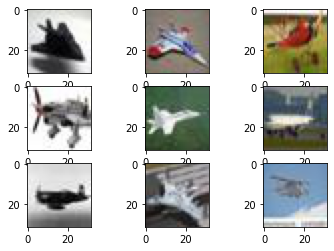

In [4]:
air_images=[]
for i in range(9):
    temp=cv2.imread(airplane[i])
    temp=cv2.cvtColor(temp,cv2.COLOR_BGR2RGB)
    air_images.append(temp)
print('이미지 사이즈 : ',temp.shape)
plt.figure(3)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(air_images[i])
    
    



## train valid 제작

In [5]:

from sklearn.model_selection import train_test_split # train , test 분리에 사용.
from collections import Counter# 라벨을 세준다.

X = []
Y = [] 

##데이터셋 합치기
X = airplane+automobile+bird+cat+deer+dog+frog+horse+ship+truck


## 라벨 제작
Y[:5000]=["airplane",]*5000
Y[5000:10000]=["automobile",]*5000
Y[10000:15000]=["bird",]*5000
Y[15000:20000]=["cat",]*5000
Y[20000:25000]=["deer",]*5000
Y[25000:30000]=["dog",]*5000
Y[30000:35000]=["frog",]*5000
Y[35000:40000]=["horse",]*5000
Y[40000:45000]=["ship",]*5000
Y[45000:50000]=["truck",]*5000

#train, validation set 분류

X, X_valid, Y, Y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=123)
print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_valid),Counter(Y_valid))
print("---")


---
훈련 셋 :  40000 Counter({'dog': 4000, 'automobile': 4000, 'cat': 4000, 'bird': 4000, 'airplane': 4000, 'ship': 4000, 'deer': 4000, 'horse': 4000, 'truck': 4000, 'frog': 4000})
테스트 셋 :  10000 Counter({'automobile': 1000, 'dog': 1000, 'airplane': 1000, 'frog': 1000, 'horse': 1000, 'truck': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'ship': 1000})
---


In [6]:
#데이터 읽어서 저장하기
#더 빠른 연산을 위해서 미리 메모리에 올려두기
#단, 메모리 용량이 큰 사람만 권함.

X=[ cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB) for x in X ]
X_valid=[ cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB) for x in X_valid ]





In [7]:
test_set_img = [ cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB) for x in test_set ]

# 데이터 정의

In [8]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]


#train, valid dataset / Y_data와 data_list만 바꿔주면 train, valid 바꿀 수 있다.
class cifar_dataset(Dataset):
    def __init__(self,data_list,Y_data,classes,transform=None):
        self.data_list = data_list # x 데이터
        self.Y_data = Y_data # y 라벨
        self.classes = classes
        
        self.label = cifar_dataset.get_label(self.data_list,self.Y_data)
        self.transform=transform
        
        
        
        
    @classmethod
    def get_label(cls,data_list,Y_data):
        label_list=[]
        for idx,x in enumerate(data_list):
            label_list.append(Y_data[idx])
        return label_list
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,idx):
        img=self.data_list[idx]
        ## resnet을 사용할 예정이라 따로 이미지 사이즈 조절은 필요없다.
        img=self.transform(img).type(torch.float32)
        
        return img, self.classes.index(self.label[idx])#원핫 인코딩
        
        

In [9]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]


#test dataset 
class cifar_test_dataset(Dataset):
    def __init__(self,data_list, path_list,classes,transform=None):
        self.data_list = data_list # x 데이터
        self.path_list = path_list #path 데이터
        
        self.classes = classes
        self.transform=transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,idx):
        img=self.data_list[idx]
        ## resnet을 사용할 예정이라 따로 이미지 사이즈 조절은 필요없다.
        img=self.transform(img).type(torch.float32)
        
        return img,self.path_list[idx]
        
        

# 데이터 로더

In [10]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 이미지데이터
EPOCHS = 40 # 전체 데이터 셋을 40번 반복

In [11]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인
#transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_loader = torch.utils.data.DataLoader(dataset = 
                                           cifar_dataset(
                                               X,
                                               Y,
                                               classes,
                                               transform=transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,# 순서가 암기되는것을 막기위해.
                                           ) 


validation_loader = torch.utils.data.DataLoader(dataset = 
                                           cifar_dataset(
                                               X_valid,
                                               Y_valid,
                                               classes,
                                               transform=transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,# 순서가 암기되는것을 막기위해.
                                           ) 

In [12]:
test_loader = torch.utils.data.DataLoader(dataset = 
                                           cifar_test_dataset(
                                               test_set_img,
                                               test_set,
                                               classes,
                                               transform=transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,# 테스트 순서 유지.
                                           ) 

# 데이터 확인

X_train :  torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(1)


Text(0, 0.5, 'Frequency')

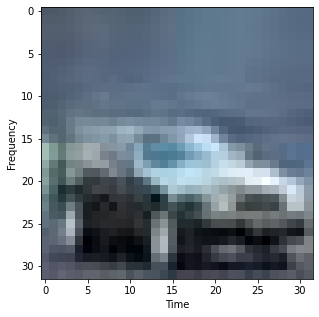

In [13]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
plt.figure(figsize=(5,5))
plt.imshow(X_train[0].permute(1,2,0).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')\
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_valid :  torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(7)


Text(0, 0.5, 'Frequency')

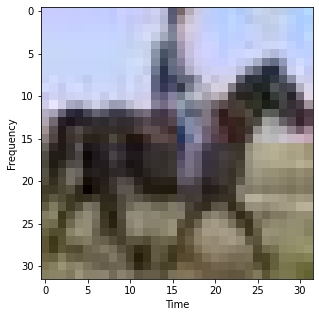

In [14]:
# 4. 데이터 확인하기
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break
    
print(Y_valid[0])
plt.figure(figsize=(5,5))
plt.imshow(X_valid[0].permute(1,2,0).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')\
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET

In [15]:
# 모델 
# pretrained

#데이터가 28*28로 단순하다 생각해서 일단 18로 진행

def model_initialize():
    model = models.resnet18(pretrained=False)
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features

    # 1000 -> 10 로 fc를 수정. class가 10개니까
    model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Linear(256, len(classes))
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [18]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [19]:
#10. 학습 및 평가.
#early stop

check_path = './checkpoint/checkpoint_resnet18.pt'
print(check_path)
early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)

best_train_acc=0 # accuracy 기록용
best_valid_acc=0

print("학습 시작\n ----- ")
for Epoch in range(1,EPOCHS+1):
    train_loss,train_accuracy = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_accuracy = evaluate(model, validation_loader)


    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
          format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))


    early_stopping(valid_loss, model)
    if -early_stopping.best_score == valid_loss:
        best_train_acc, best_valid_acc = train_accuracy,valid_accuracy

    if early_stopping.early_stop:
            print("최고 train acc",best_train_acc)
            print("최고 valid acc",best_valid_acc)
            break

    if Epoch==EPOCHS:
        #만약 early stop 없이 마지막 epoch라서 중지 된 경우.
        print("최고 train acc",best_train_acc)
        print("최고 valid acc",best_valid_acc)

./checkpoint/checkpoint_resnet18.pt
학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0487	 Train Acc:44.20 %  | 	Valid Loss:0.0422 	Valid Acc: 51.53 %

Validation loss decreased (inf --> 0.042235).  Saving model ...

[EPOCH:2]	 Train Loss:0.0382	 Train Acc:56.71 %  | 	Valid Loss:0.0378 	Valid Acc: 57.30 %

Validation loss decreased (0.042235 --> 0.037831).  Saving model ...

[EPOCH:3]	 Train Loss:0.0323	 Train Acc:64.00 %  | 	Valid Loss:0.0343 	Valid Acc: 61.39 %

Validation loss decreased (0.037831 --> 0.034268).  Saving model ...

[EPOCH:4]	 Train Loss:0.0275	 Train Acc:69.31 %  | 	Valid Loss:0.0336 	Valid Acc: 62.51 %

Validation loss decreased (0.034268 --> 0.033639).  Saving model ...

[EPOCH:5]	 Train Loss:0.0235	 Train Acc:73.92 %  | 	Valid Loss:0.0333 	Valid Acc: 63.57 %

Validation loss decreased (0.033639 --> 0.033335).  Saving model ...

[EPOCH:6]	 Train Loss:0.0193	 Train Acc:78.72 %  | 	Valid Loss:0.0336 	Valid Acc: 64.74 %

EarlyStopping counter: 1 out of 5

[EPOCH:7]	 Train Loss:0

# Test

In [23]:
check_path = './checkpoint/checkpoint_resnet18.pt'
model.load_state_dict(torch.load(check_path))

prediction_list = []
file_list = []

with torch.no_grad():
    for image,path in test_loader:
        image = image.to(DEVICE)
        output = model(image)
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        
        prediction_list+=prediction.cpu().numpy().tolist()
        file_list+=path
        #print(prediction)

In [24]:
prediction_list=[ classes[data[0]] for data in prediction_list ]# class 명으로 바꿔주기. 0번 인덱스인 이유는 넘파이가 [5] 이런 형태로 출력되서


print(prediction_list[:10])

['horse', 'frog', 'automobile', 'horse', 'airplane', 'deer', 'bird', 'ship', 'airplane', 'dog']


In [25]:
file_list=[name.split("\\")[-1] for name in file_list] #file list 이름 전처리


print(file_list[:10])

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg']


In [26]:
DF=pd.DataFrame({'id':file_list,'target':prediction_list})
DF

,id,target
0,0000.jpg,horse
1,0001.jpg,frog
2,0002.jpg,automobile
3,0003.jpg,horse
4,0004.jpg,airplane
...,...,...
9995,9995.jpg,dog
9996,9996.jpg,cat
9997,9997.jpg,deer
9998,9998.jpg,automobile


In [27]:
DF.to_csv("./res18_result.csv",index=False)